# **Detectron2 Instance Segmentation on Solar Panel Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Installing Detectron2 on Colab**

In [ ]:
!pip install -q pyyaml==5.1
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q tqdm
!git clone -q https://github.com/facebookresearch/detectron2.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.6/763.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.8.0+cu101 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu101 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 8.0 MB/s eta 0:00:00
     ━

In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

## **Register the data to Detectron2 config**

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
# # function to create a dictionary of annotations and their objects
# def get_data_dicts(directory, classes):
#     dataset_dicts = []
#     for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
#         json_file = os.path.join(directory, filename)
#         with open(json_file) as f:
#             img_anns = json.load(f)

#         record = {}
#         imgPath = img_anns["imagePath"].split('/')[-1]
#         filename = os.path.join(directory, imgPath)
        
#         record["file_name"] = filename
#         record["height"] = 1080
#         record["width"] = 1920
      
#         annos = img_anns["shapes"]
#         objs = []
#         for anno in annos:
#             px = [a[0] for a in anno['points']] # x coord
#             py = [a[1] for a in anno['points']] # y-coord
#             poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": classes.index(anno['label']), #original
#                 # "category_id": classes.index(anno['label'] if anno['label']=='panel' else 'panel'), #edited
#                 "iscrowd": 0
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts


# # Registering train and test dataset to detectron2 module
# classes = ['panel']

# data_path = '/content/drive/MyDrive/Temp_files/panel_visible/'
# # data_path = '/content/drive/MyDrive/Temp_files/panel_new_perfect/'

# for d in ["train", "test"]:
#     DatasetCatalog.register("category_" + d, lambda d=d: get_data_dicts(data_path+d, classes))
#     MetadataCatalog.get("category_" + d).set(thing_classes=classes)

# microcontroller_metadata = MetadataCatalog.get("category_train")

In [ ]:
# Alternate method to register detectron2 using COCO.json format
from detectron2.data.datasets import register_coco_instances
register_coco_instances("category_train",{}, '/content/drive/MyDrive/Temp_files/solar_visible_coco2/train/_annotations.coco.json', '/content/drive/MyDrive/Temp_files/solar_visible_coco2/train')
register_coco_instances("category_test",{},'/content/drive/MyDrive/Temp_files/solar_visible_coco2/test/_annotations.coco.json', '/content/drive/MyDrive/Temp_files/solar_visible_coco2/test')

microcontroller_metadata = MetadataCatalog.get("category_train")
# dataset_train = DatasetCatalog.get(Data_Resister_training)
# dataset_valid = DatasetCatalog.get(Data_Resister_test)

 ## **Training the Detectron2 Instance Segmentation Model**

### **Model Building**

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.projects import point_rend
from detectron2.modeling import build_model
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

In [ ]:
# PointRend Segmentation model building
cfg = get_cfg() 
point_rend.add_pointrend_config(cfg)
cfg.merge_from_file("detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml")
# cfg.merge_from_file("detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_101_FPN_3x_coco.yaml")
# cfg.merge_from_file("detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")

cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco/28119989/model_final_ba17b9.pkl"
# cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_101_FPN_3x_coco/28119983/model_final_3f4d2a.pkl"
# cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000

In [ ]:
# # Instance segmentation model building
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("category_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.MAX_ITER = 1000
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

### **Model Training** (Dont need to run if model weights are present)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

[12/31 06:55:13 d2.engine.train_loop]: Starting training from iteration 0
[12/31 06:55:51 d2.utils.events]:  eta: 2:35:50  iter: 19  total_loss: 12.26  loss_cls: 2.526  loss_box_reg: 0.1188  loss_mask: 0.9143  loss_mask_point: 0.6502  loss_rpn_cls: 7.862  loss_rpn_loc: 0.3923  time: 1.8522  data_time: 0.1098  lr: 4.9953e-06  max_mem: 9146M
[12/31 06:56:29 d2.utils.events]:  eta: 2:37:22  iter: 39  total_loss: 5.333  loss_cls: 1.219  loss_box_reg: 0.6422  loss_mask: 0.3886  loss_mask_point: 0.5397  loss_rpn_cls: 2.316  loss_rpn_loc: 0.2469  time: 1.8584  data_time: 0.0280  lr: 9.9902e-06  max_mem: 9163M
[12/31 06:57:06 d2.utils.events]:  eta: 2:37:19  iter: 59  total_loss: 1.821  loss_cls: 0.3272  loss_box_reg: 0.2855  loss_mask: 0.2198  loss_mask_point: 0.4155  loss_rpn_cls: 0.3807  loss_rpn_loc: 0.1396  time: 1.8554  data_time: 0.0300  lr: 1.4985e-05  max_mem: 9163M
[12/31 06:57:43 d2.utils.events]:  eta: 2:37:11  iter: 79  total_loss: 1.096  loss_cls: 0.211  loss_box_reg: 0.1876  los

In [ ]:
# Saving the trained model weights 
from google.colab import files 
files.download("/content/output/model_final.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Inference using the Trained Model**

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Temp_files/output_10000/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("category_test", )
predictor = DefaultPredictor(cfg)

### Instance Segmentation Model Inference

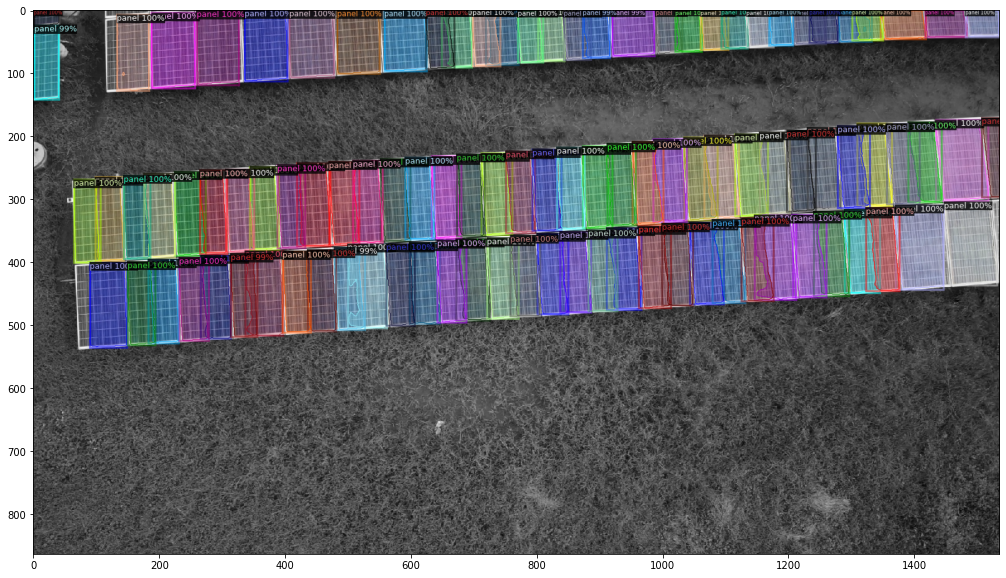

In [ ]:
# predicting on single test data
img = cv2.imread('/content/drive/MyDrive/Temp_files/panel_visible/test/DJI_0703_W-FNo456.jpeg')
# img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
               metadata=microcontroller_metadata, 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (20, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# predicting on test data using instance segmentation
test_dataset_dicts = get_data_dicts(data_path+'test', classes)
for d in random.sample(test_dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

### PointRend Model Inference

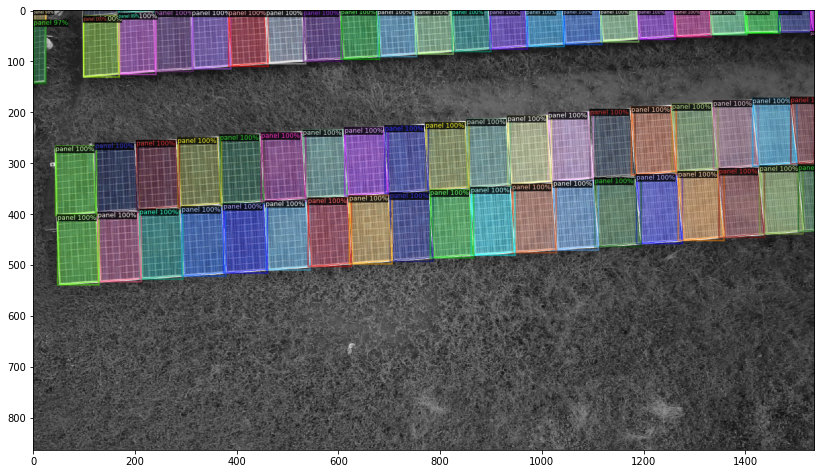

In [ ]:
# predicting on test data using PointRend segmentation
test_dataset_dicts = get_data_dicts(data_path+'test', classes)
for d in random.sample(test_dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Before Instance Segmentation:

39 400 86 476


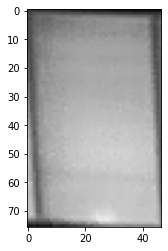

In [ ]:
# displaying single panel bounding box
boxes = outputs["instances"].pred_boxes
boxes = list(boxes)[16].detach().cpu().numpy()

# extract the bounding box coordinates
(x0, y0) = (int(boxes[0]), int(boxes[1]))
(x1, y1) = (int(boxes[2]), int(boxes[3]))

crop_img = img[y0:y1, x0:x1]
print(x0, y0, x1, y1)
plt.imshow(crop_img)

After Instance Segmentation:

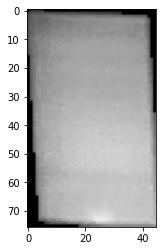

In [ ]:
# collecting single panel-mask inside bounding box
one_mask = np.asarray(outputs["instances"].pred_masks[16].to("cpu"))
segmentation = np.where(one_mask == True)

x_min = int(np.min(segmentation[1]))
x_max = int(np.max(segmentation[1]))
y_min = int(np.min(segmentation[0]))
y_max = int(np.max(segmentation[0]))

cropped = Image.fromarray(img[y_min:y_max, x_min:x_max, :], mode='RGB') # Create a cropped image from just the portion of the image we want
mask = Image.fromarray((one_mask * 255).astype('uint8')) # Create a PIL image out of the mask
cropped_mask = mask.crop((x_min, y_min, x_max, y_max)).convert('RGB')
paste_position = (0, 0)

alpha_mask = Image.new('L', cropped.size,  color = 0)
alpha_mask.paste(cropped_mask, paste_position)

composite = Image.composite(cropped, cropped_mask, alpha_mask) # Compose the foreground and background using the alpha mask
composite_array = np.array(composite)

plt.imshow(composite_array)

Collecting output panel masks of single image into a seperate directory:

In [ ]:
# collecting multiple panel-masks and saving them into a directory
!mkdir /content/drive/MyDrive/Temp_files/output_masks2/

pred_masks_np = np.asarray(outputs["instances"].pred_masks.to("cpu"))
pred_cls = outputs["instances"].pred_classes
pred_conf = outputs["instances"].scores
panel_instances = []
panel_count=1

for one_mask, cls, conf in zip(pred_masks_np, pred_cls, pred_conf):
  if classes[int(cls)] == "panel" and conf >= 0.5:

    # Get the true bounding box of the mask (not the same as the bbox prediction)
    segmentation = np.where(one_mask == True)
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))
    
    cropped = Image.fromarray(img[y_min:y_max, x_min:x_max, :], mode='RGB') # Create a cropped image from just the portion of the image we want
    mask = Image.fromarray((one_mask * 255).astype('uint8')) # Create a PIL image out of the mask
    cropped_mask = mask.crop((x_min, y_min, x_max, y_max)).convert('RGB') # Crop the mask to match the cropped image
    paste_position = (0, 0) # Choose a paste position

    # Create a new alpha mask as large as the composite and paste the cropped mask
    alpha_mask = Image.new('L', cropped.size, color = 0)
    alpha_mask.paste(cropped_mask, paste_position)

    composite = Image.composite(cropped, cropped_mask, alpha_mask) # Compose the foreground and background using the alpha mask
    composite_array = np.array(composite)
    panel_instances.append(composite_array[:, :, ::-1])

    composite.save("/content/drive/MyDrive/Temp_files/output_masks2/" + str(panel_count) + ".png")
    panel_count += 1


Prediction on different angled test data(zoomed out):

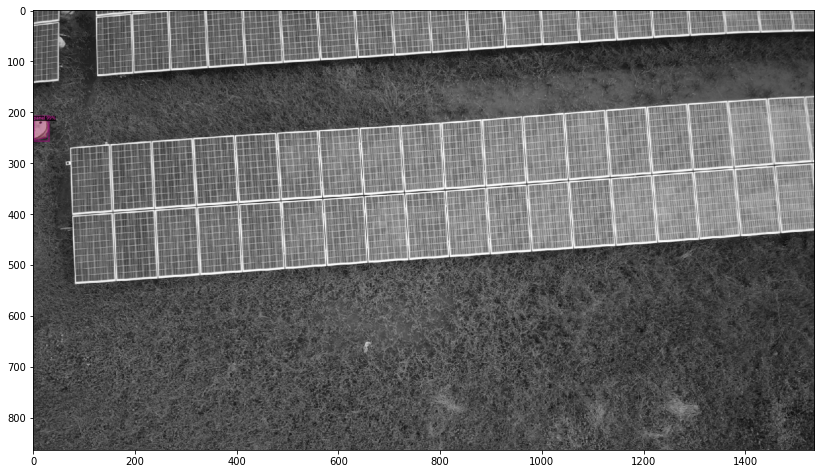

In [ ]:
# predicting on another test data with different angle
img = cv2.imread('/content/DJI_0703_W-FNo455.jpeg')
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
               metadata=microcontroller_metadata, 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW) # removes the colors of unsegmented pixels

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14,20))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

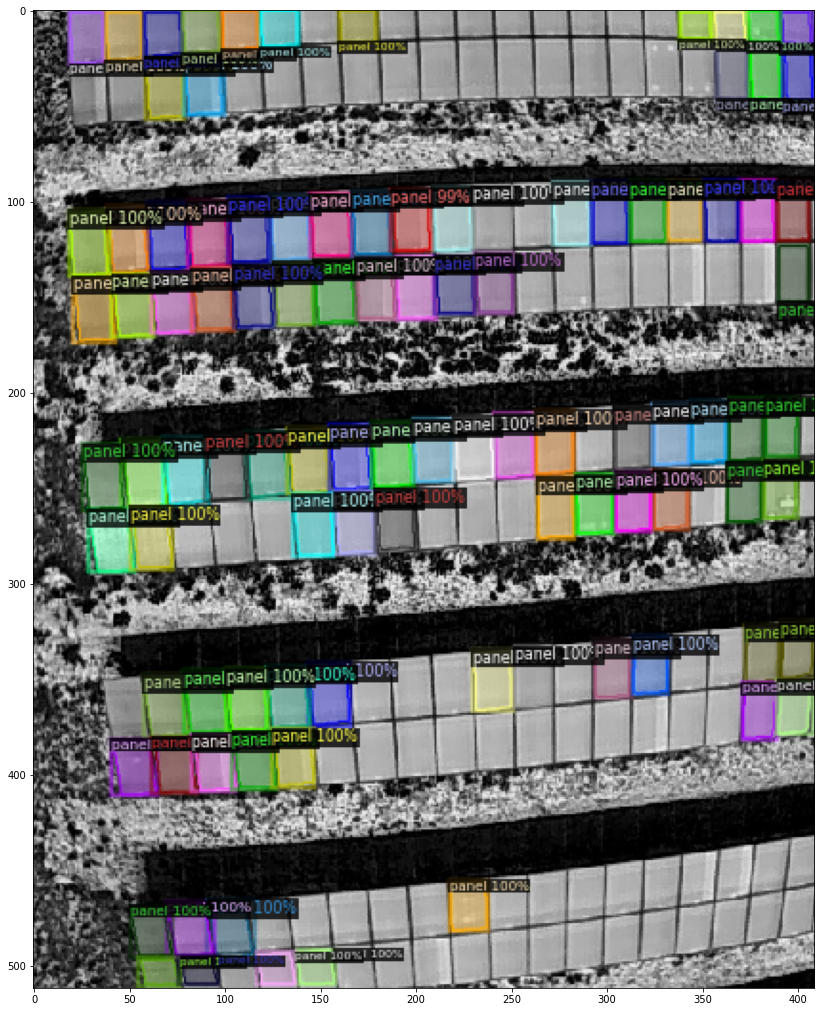

In [ ]:
# predicting on another test data with different angle
img = cv2.imread('/content/frst.jpeg')
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
               metadata=microcontroller_metadata, 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW) # removes the colors of unsegmented pixels

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14,20))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

We observe that PointRend model possesses higher accuracy in prediction and segmentation; Therefore, it is an optimum choice.

### PointRend Model prediction on Video

In [ ]:
# video = cv2.VideoCapture('/content/new_trim.mp4')
video = cv2.VideoCapture('/content/drive/MyDrive/Temp_files/trim_ir_rotated.mp4')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer
video_writer = cv2.VideoWriter('out.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                               fps=float(frames_per_second), frameSize=(width, height), isColor=True)

# Initialize visualizer
v = VideoVisualizer(metadata=microcontroller_metadata, 
                    instance_mode=ColorMode.IMAGE_BW)

def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """

    out = []  
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
          
        # print(type(outputs['instances'].pred_boxes.to('cpu')))
        s=(outputs["instances"].pred_boxes.to('cpu'))
        out.append(s)

        yield visualization, out

        readFrames += 1
        if readFrames > maxFrames:
            break

# Create a cut-off for debugging
num_frames = 73
f_out = []

# Enumerate the frames of the video
for visualization, outputs in tqdm(runOnVideo(video, num_frames), total=num_frames):

    # Write test image
    cv2.imwrite('POSE detectron2.png', visualization)
    f_out=outputs

    # Write to video file
    video_writer.write(visualization)

# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()

74it [01:25,  1.16s/it]


### Running Inference on New test dataset (1750 images)

In [ ]:
# !mkdir /content/drive/MyDrive/Temp_files/output_masks_1732/
!mkdir /content/dummy/

def mask_maker(outputs, panel_count, img_no):
  pred_masks_np = np.asarray(outputs["instances"].pred_masks.to("cpu"))
  pred_cls = outputs["instances"].pred_classes
  pred_conf = outputs["instances"].scores
  panel_instances = []
  
  for one_mask, cls, conf in zip(pred_masks_np, pred_cls, pred_conf):
    if classes[int(cls)] == "panel" and conf >= 0.7:
    
      # Get the true bounding box of the mask (not the same as the bbox prediction)
      segmentation = np.where(one_mask == True)
      x_min = int(np.min(segmentation[1]))
      x_max = int(np.max(segmentation[1]))
      y_min = int(np.min(segmentation[0]))
      y_max = int(np.max(segmentation[0]))

      area=(x_max-x_min)*(y_max-y_min)
      if area<2400: #checking for complete panel area pixels
        continue
      
      cropped = Image.fromarray(img[y_min:y_max, x_min:x_max, :], mode='RGB') # Create a cropped image from just the portion of the image we want
      mask = Image.fromarray((one_mask * 255).astype('uint8')) # Create a PIL image out of the mask
      cropped_mask = mask.crop((x_min, y_min, x_max, y_max)).convert('RGB') # Crop the mask to match the cropped image
      paste_position = (0, 0) # Choose a paste position
  
      # Create a new alpha mask as large as the composite and paste the cropped mask
      alpha_mask = Image.new('L', cropped.size, color = 0)
      alpha_mask.paste(cropped_mask, paste_position)
  
      composite = Image.composite(cropped, cropped_mask, alpha_mask) # Compose the foreground and background using the alpha mask
      composite_array = np.array(composite)
      panel_instances.append(composite_array[:, :, ::-1])
  
      composite.save("/content/dummy/" + str(panel_count) + ".png")
      # composite.save("/content/drive/MyDrive/Temp_files/output_masks_1732/" + img_no + '_' + str(panel_count) + ".png")
      panel_count += 1

  return panel_count

In [ ]:
directory = '/content/drive/MyDrive/Temp_files/solar_array_1732'
panel_count = 1
file_count = 0
for file in os.listdir(directory):
    print(file)
    img = cv2.imread(os.path.join(directory, file))
    img_no = file.split('-')[1]
    img_no = img_no.split('.')[0]    
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, 
                   scale=0.8, instance_mode=ColorMode.IMAGE_BW) # removes the colors of unsegmented pixels
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) # predicts instances and moves to 'cpu'
    panel_count = mask_maker(outputs, panel_count, img_no) # function to create masks and save in the specified directory
    file_count += 1
    
    print(file_count, os.path.join(directory, file), panel_count)

DJI_0761_T-FNo24376.jpeg
1 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0761_T-FNo24376.jpeg 55
DJI_0761_T-FNo24576.jpeg
2 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0761_T-FNo24576.jpeg 109
DJI_0761_T-FNo24716.jpeg
3 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0761_T-FNo24716.jpeg 162
DJI_0761_T-FNo24829.jpeg
4 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0761_T-FNo24829.jpeg 216
DJI_0763_T-FNo1.jpeg
5 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0763_T-FNo1.jpeg 260
DJI_0757_T-FNo659.jpeg
6 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0757_T-FNo659.jpeg 274
DJI_0757_T-FNo798.jpeg
7 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0757_T-FNo798.jpeg 288
DJI_0757_T-FNo869.jpeg
8 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0757_T-FNo869.jpeg 302
DJI_0757_T-FNo893.jpeg
9 /content/drive/MyDrive/Temp_files/solar_array_1732/DJI_0757_T-FNo893.jpeg 316
DJI_0757_T-FNo957.jpeg
10 /content/drive/MyDrive/Temp_files/so

In [ ]:
count=0
for file in os.listdir('/content/drive/MyDrive/Temp_files/output_masks_1732'):
  count+=1
print(count, 'panels detected!')

57033 panels detected!
